# Sentiment Analysis

Sentiment analysis refers to any algorithms that is capable of identifying the emotional tone of the message within a
text.

Below we will consider the dataset 'labelled reviews' containing the text of 462744 reviews with their respective ratings - positive, negative or neutral. After a preprocessing and tokenization procedure of the text, we used the TF/IDF approach to extract the features to be used in the models. Therefore, after splitting the data into training (80%) and test (20%) sets and solving the problem of unbalanced classes by undersampling (only for training set), we evaluated the performance of the Logistic model, Random Forest and SVM. The best of these was then used to evaluate the sentiment of the customer reviews dataset.

In [24]:
import pandas as pd
import re
import nltk
import string
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import demoji
import contractions

from pandarallel import pandarallel

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Enrico\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Enrico\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Enrico\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Let's import the data:

In [3]:
labelled_reviews = pd.read_csv('tbl_labelled_reviews.csv')
labelled_reviews

,labelled_reviews_index,review_text,sentiment_label
0,0,I'm no bitters expert but I bought it as a gif...,neutral
1,1,"these are probably great in the right drinks, ...",neutral
2,2,I sent these to my dad for his bday and he sai...,positive
3,3,I purchased these as a gift for family member ...,positive
4,4,My wife bought me this sauce sampler for Chris...,neutral
...,...,...,...
462739,462739,Great for sesame chicken..this is a good if no...,positive
462740,462740,I'm disappointed with the flavor. The chocolat...,neutral
462741,462741,"These stars are small, so you can give 10-15 o...",positive
462742,462742,These are the BEST treats for training and rew...,positive


For each of the 462744 reviews we have its text and sentiment label (positive, neutral or negative).

## Text preprocessing

We define two functions below, the first of which will serve to clean up the text while the second will remove any remaining grammatical contractions:

In [8]:
def preprocess_text(text):
    text = text.lower() # to lowercase
    text = re.sub(r'http\S+', '', text) # remove http
    text = re.sub(r"www\S+", '', text) # remove links
    text = re.sub(r'<[^>]+>', ' ', text) # remove html
    text = demoji.replace(text, '') # remove emoji
    text = text.replace('\\n', ' ') # remove '\n' characters
    text = text.replace('\n', ' ')
    text = text.replace('\t',' ') # remove tabs
    text = re.sub(r'[^A-Za-z\s]', '', text) # remove punctuation and numbers
    preprocessed_text = re.sub(r'\s\s+', ' ', text).strip() # remove whitespaces
    return preprocessed_text

In [4]:
def decontractions(string):
    string = re.sub(r"cannot", "can not", string)
    string = re.sub(r"cant", "can not", string)
    return contractions.fix(string)

To speed up the process, we parallelise operations on all CPUs:

In [5]:
pandarallel.initialize(
    nb_workers=4,
    progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [ ]:
labelled_reviews['preprocessed_text'] = labelled_reviews['review_text'].apply(preprocess_text)
labelled_reviews['preprocessed_text'] = labelled_reviews['preprocessed_text'].apply(decontractions)
labelled_reviews

### TOKENIZATION

We tokenize the text, also removing the English stop words:

In [12]:
def tokenize_text(text):
    tokens = word_tokenize(text) #tokenize
    stop_words = set(stopwords.words('english'))  #remove english stopwords
    tokenized_text = [word for word in tokens if word not in stop_words]
    return tokenized_text

In [ ]:
labelled_reviews['tokenized_text'] = labelled_reviews['preprocessed_text'].apply(tokenize_text)
labelled_reviews

,labelled_reviews_index,review_text,sentiment_label,preprocessed_text,tokenized_text
0,0,I'm no bitters expert but I bought it as a gif...,neutral,i am no bitters expert but i bought it as a gi...,"[bitters, expert, bought, gift, friend, surpri..."
1,1,"these are probably great in the right drinks, ...",neutral,these are probably great in the right drinks b...,"[probably, great, right, drinks, like, old, fa..."
2,2,I sent these to my dad for his bday and he sai...,positive,i sent these to my dad for his birthday and he...,"[sent, dad, birthday, said, really, pretty, go..."
3,3,I purchased these as a gift for family member ...,positive,i purchased these as a gift for family member ...,"[purchased, gift, family, member, loves, bbq, ..."
4,4,My wife bought me this sauce sampler for Chris...,neutral,my wife bought me this sauce sampler for chris...,"[wife, bought, sauce, sampler, christmas, know..."
...,...,...,...,...,...
462739,462739,Great for sesame chicken..this is a good if no...,positive,great for sesame chickenthis is a good if not ...,"[great, sesame, chickenthis, good, better, res..."
462740,462740,I'm disappointed with the flavor. The chocolat...,neutral,i am disappointed with the flavor the chocolat...,"[disappointed, flavor, chocolate, notes, espec..."
462741,462741,"These stars are small, so you can give 10-15 o...",positive,these stars are small so you can give of those...,"[stars, small, give, one, training, session, t..."
462742,462742,These are the BEST treats for training and rew...,positive,these are the best treats for training and rew...,"[best, treats, training, rewarding, dog, good,..."


### LEMMATIZATION

Finally, we proceed with the lemmatisation of the tokenized text, a process which involves the reduction of words to their basic form or root, known as a lemma.

In [13]:
lemmatizer = WordNetLemmatizer()

def lemmatize_first(words):
    lemmatized_words = [lemmatizer.lemmatize(word, 'v') for word in words]
    return lemmatized_words

def lemmatize_second(words):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return lemmatized_words

In [ ]:
labelled_reviews['lemmatized_text'] = labelled_reviews['tokenized_text'].apply(lemmatize_first)
labelled_reviews['lemmatized_text'] = labelled_reviews['lemmatized_text'].apply(lemmatize_second)
labelled_reviews[['tokenized_text', 'lemmatized_text']]

,tokenized_text,lemmatized_text
0,"[bitters, expert, bought, gift, friend, surpri...","[bitter, expert, buy, gift, friend, surprise, ..."
1,"[probably, great, right, drinks, like, old, fa...","[probably, great, right, drink, like, old, fas..."
2,"[sent, dad, birthday, said, really, pretty, go...","[send, dad, birthday, say, really, pretty, goo..."
3,"[purchased, gift, family, member, loves, bbq, ...","[purchase, gift, family, member, love, bbq, po..."
4,"[wife, bought, sauce, sampler, christmas, know...","[wife, buy, sauce, sampler, christmas, know, l..."
...,...,...
462739,"[great, sesame, chickenthis, good, better, res...","[great, sesame, chickenthis, good, better, res..."
462740,"[disappointed, flavor, chocolate, notes, espec...","[disappoint, flavor, chocolate, note, especial..."
462741,"[stars, small, give, one, training, session, t...","[star, small, give, one, train, session, try, ..."
462742,"[best, treats, training, rewarding, dog, good,...","[best, treat, train, reward, dog, good, groom,..."


We save the dataset so as to avoid re-running the cleaning process.

In [ ]:
labelled_reviews.to_csv('processed_text.csv', index=False)

## Text representation

In [25]:
preprocessed_text = pd.read_csv('processed_text.csv')
text = preprocessed_text['lemmatized_text']
text

0         ['bitter', 'expert', 'buy', 'gift', 'friend', ...
1         ['probably', 'great', 'right', 'drink', 'like'...
2         ['send', 'dad', 'birthday', 'say', 'really', '...
3         ['purchase', 'gift', 'family', 'member', 'love...
4         ['wife', 'buy', 'sauce', 'sampler', 'christmas...
                                ...                        
462739    ['great', 'sesame', 'chickenthis', 'good', 'be...
462740    ['disappoint', 'flavor', 'chocolate', 'note', ...
462741    ['star', 'small', 'give', 'one', 'train', 'ses...
462742    ['best', 'treat', 'train', 'reward', 'dog', 'g...
462743    ['satisfy', 'product', 'advertise', 'use', 'ce...
Name: lemmatized_text, Length: 462744, dtype: object

We divide the dataset into training (80%) and test (20%) set:

In [19]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_text['lemmatized_text'], preprocessed_text['sentiment_label'], test_size=0.2, random_state=42)

In [20]:
print(X_train.shape)
print(X_test.shape)

(370195,)
(92549,)


In [21]:
y_train_counts = y_train.value_counts()
y_train_counts

positive    237618
neutral      98750
negative     33827
Name: sentiment_label, dtype: int64

Considering the distribution of labels in the training set, we clearly see that we are in an unbalanced class problem:

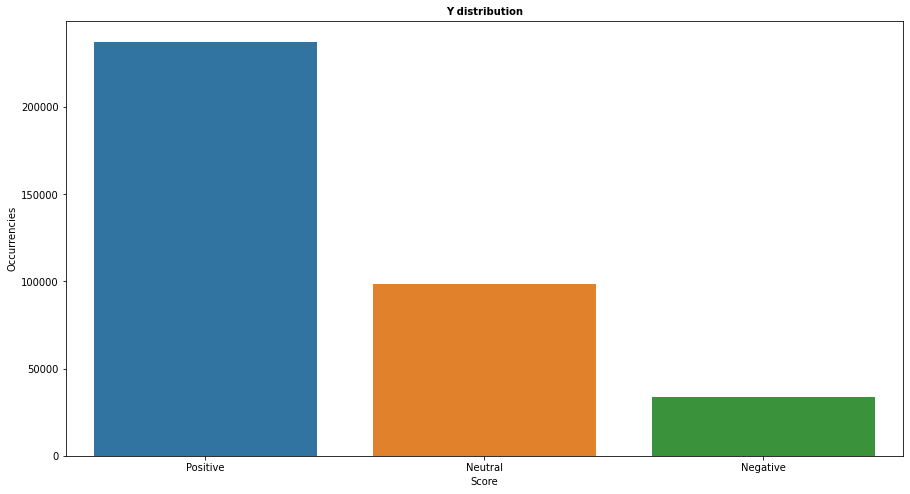

In [6]:
plt.figure(figsize=(15,8))
sns.countplot(x = y_train, order = y_train_counts.index)

plt.title("Y distribution", fontweight='bold', fontsize=10)
plt.xlabel("Score")
plt.ylabel("Occurrencies")
plt.xticks(np.arange(0,3,1), ['Positive', 'Neutral', 'Negative'])
plt.show()

### Class balancing - undersampling

To solve the problem of unbalanced classes, we proceed by undersampling the majority classes:

In [22]:
df = pd.concat([X_train, pd.DataFrame({'sentiment_label': y_train})], axis=1)

undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(df.drop('sentiment_label', axis=1), df['sentiment_label'])

Now the problem is solved and each class has the same numerosity:

In [8]:
y_resampled.value_counts()

negative    33827
positive    33827
neutral     33827
Name: sentiment_label, dtype: int64

### TF-IDF

For text representation, we consider the TF-IDF, which takes into account both the frequency of a term in a document (TF) and its rarity in the entire document collection (IDF).

In [26]:
vect_tfidf = TfidfVectorizer(min_df = 0.001)

In [24]:
X_train_tfidf = vect_tfidf.fit_transform(X_resampled['lemmatized_text'])
X_train_tfidf.shape

(101481, 2962)

In [25]:
X_test_tfidf = vect_tfidf.transform(X_test)
X_test_tfidf.shape

(92549, 2962)

## Classification

### Logistic model

In [26]:
logreg = LogisticRegression(max_iter=100, random_state=42)
logreg = logreg.fit(X_train_tfidf, y_resampled)

c:\Users\Enrico\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Let's see metrics on the training set:

In [27]:
y_pred_train = logreg.predict(X_train_tfidf)
print(classification_report(y_pred_train, y_resampled))

              precision    recall  f1-score   support

    negative       0.82      0.79      0.81     35067
     neutral       0.63      0.67      0.65     31767
    positive       0.78      0.76      0.77     34647

    accuracy                           0.74    101481
   macro avg       0.74      0.74      0.74    101481
weighted avg       0.75      0.74      0.75    101481



Let's see metrics on the test set:

In [28]:
y_pred_test = logreg.predict(X_test_tfidf)
print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

    negative       0.80      0.48      0.60     14377
     neutral       0.60      0.53      0.57     27756
    positive       0.75      0.88      0.81     50416

    accuracy                           0.72     92549
   macro avg       0.72      0.63      0.66     92549
weighted avg       0.71      0.72      0.70     92549



Let's see the confusion matrix:

Text(0.5, 1.0, 'Confusion Matrix')

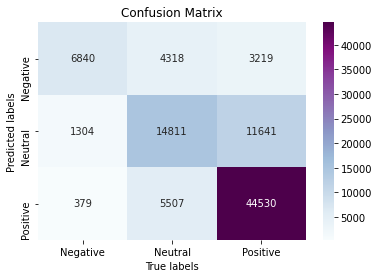

In [16]:
cm = confusion_matrix(y_pred_test, y_test)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', cmap="BuPu")
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_yticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.set_title('Confusion Matrix')

### Random Forest model

In [17]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=4, max_depth=10, random_state=42)
rf = rf.fit(X_train_tfidf, y_resampled)

In [18]:
y_pred_train = rf.predict(X_train_tfidf)
print(classification_report(y_pred_train, y_resampled))

              precision    recall  f1-score   support

    negative       0.73      0.75      0.74     33099
     neutral       0.52      0.64      0.57     27165
    positive       0.76      0.62      0.68     41217

    accuracy                           0.67    101481
   macro avg       0.67      0.67      0.66    101481
weighted avg       0.68      0.67      0.67    101481



In [19]:
y_pred_test = rf.predict(X_test_tfidf)
print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

    negative       0.71      0.38      0.50     15757
     neutral       0.49      0.50      0.50     24003
    positive       0.73      0.83      0.78     52789

    accuracy                           0.67     92549
   macro avg       0.64      0.57      0.59     92549
weighted avg       0.67      0.67      0.66     92549



Text(0.5, 1.0, 'Confusion Matrix')

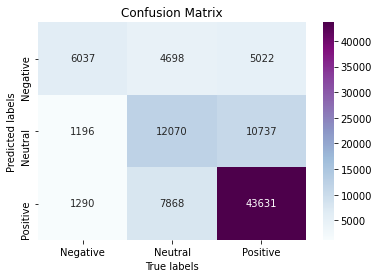

In [20]:
cm = confusion_matrix(y_pred_test, y_test)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', cmap="BuPu")
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_yticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.set_title('Confusion Matrix')

### SVM model

In [32]:
rbf_feature = RBFSampler(random_state = 42)
X_features = rbf_feature.fit_transform(X_train_tfidf)

svm = SGDClassifier(alpha=0.0001, eta0=0.1)
svm = svm.fit(X_features, y_resampled)

In [33]:
y_pred_train = svm.predict(X_features)
print(classification_report(y_pred_train, y_resampled))

              precision    recall  f1-score   support

    negative       0.24      0.46      0.32     17614
     neutral       0.35      0.37      0.36     32757
    positive       0.57      0.38      0.46     51110

    accuracy                           0.39    101481
   macro avg       0.39      0.40      0.38    101481
weighted avg       0.44      0.39      0.40    101481



In [34]:
y_pred_test = svm.predict(rbf_feature.transform(X_test_tfidf))
print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

    negative       0.24      0.15      0.19     13231
     neutral       0.36      0.30      0.33     29944
    positive       0.57      0.68      0.62     49374

    accuracy                           0.48     92549
   macro avg       0.39      0.38      0.38     92549
weighted avg       0.45      0.48      0.46     92549



Text(0.5, 1.0, 'Confusion Matrix')

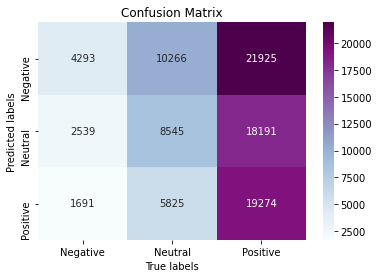

In [26]:
cm = confusion_matrix(y_pred_test, y_test)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', cmap="BuPu")
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_yticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.set_title('Confusion Matrix')

## Sentiment analysis on customer reviews

The best performing model was the Logistic one, so we now train it on the entire dataset and use it to classify unlabelled customer reviews (dataset *tbl_customer_reviews*). 

We reapply the same pre-processing operations done previously on the new dataset:

In [27]:
reviews = pd.read_csv('tbl_customer_reviews.csv')
reviews.drop('review_id', axis=1, inplace=True)
reviews

,customer_id,review_text
0,814256,I have bought several of the Vitality canned d...
1,457475,Product arrived labeled as Jumbo Salted Peanut...
2,104045,This is a confection that has been around a fe...
3,603662,If you are looking for the secret ingredient i...
4,739314,Great taffy at a great price. There was a wid...
...,...,...
105705,224091,"We Love,Love our Keurig coffee maker .My husba..."
105706,196666,This is supposed to be a light roast coffee bu...
105707,618226,I have always been happy with my Kcups but thi...
105708,844918,I ordered light roast coffee and was sent one ...


In [10]:
reviews['preprocessed_text'] = reviews['review_text'].apply(preprocess_text)
reviews['preprocessed_text'] = reviews['preprocessed_text'].apply(decontractions)
reviews

,customer_id,review_text,preprocessed_text
0,814256,I have bought several of the Vitality canned d...,i have bought several of the vitality canned d...
1,457475,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled as jumbo salted peanut...
2,104045,This is a confection that has been around a fe...,this is a confection that has been around a fe...
3,603662,If you are looking for the secret ingredient i...,if you are looking for the secret ingredient i...
4,739314,Great taffy at a great price. There was a wid...,great taffy at a great price there was a wide ...
...,...,...,...
105705,224091,"We Love,Love our Keurig coffee maker .My husba...",we lovelove our keurig coffee maker my husband...
105706,196666,This is supposed to be a light roast coffee bu...,this is supposed to be a light roast coffee bu...
105707,618226,I have always been happy with my Kcups but thi...,i have always been happy with my kcups but thi...
105708,844918,I ordered light roast coffee and was sent one ...,i ordered light roast coffee and was sent one ...


In [14]:
reviews['tokenized_text'] = reviews['preprocessed_text'].apply(tokenize_text)
reviews

,customer_id,review_text,preprocessed_text,tokenized_text
0,814256,I have bought several of the Vitality canned d...,i have bought several of the vitality canned d...,"[bought, several, vitality, canned, dog, food,..."
1,457475,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled as jumbo salted peanut...,"[product, arrived, labeled, jumbo, salted, pea..."
2,104045,This is a confection that has been around a fe...,this is a confection that has been around a fe...,"[confection, around, centuries, light, pillowy..."
3,603662,If you are looking for the secret ingredient i...,if you are looking for the secret ingredient i...,"[looking, secret, ingredient, robitussin, beli..."
4,739314,Great taffy at a great price. There was a wid...,great taffy at a great price there was a wide ...,"[great, taffy, great, price, wide, assortment,..."
...,...,...,...,...
105705,224091,"We Love,Love our Keurig coffee maker .My husba...",we lovelove our keurig coffee maker my husband...,"[lovelove, keurig, coffee, maker, husband, liv..."
105706,196666,This is supposed to be a light roast coffee bu...,this is supposed to be a light roast coffee bu...,"[supposed, light, roast, coffee, states, extra..."
105707,618226,I have always been happy with my Kcups but thi...,i have always been happy with my kcups but thi...,"[always, happy, kcups, particular, box, good, ..."
105708,844918,I ordered light roast coffee and was sent one ...,i ordered light roast coffee and was sent one ...,"[ordered, light, roast, coffee, sent, one, box..."


In [15]:
reviews['lemmatized_text'] = reviews['tokenized_text'].apply(lemmatize_first)
reviews['lemmatized_text'] = reviews['lemmatized_text'].apply(lemmatize_second)
reviews[['tokenized_text', 'lemmatized_text']]

,tokenized_text,lemmatized_text
0,"[bought, several, vitality, canned, dog, food,...","[buy, several, vitality, can, dog, food, produ..."
1,"[product, arrived, labeled, jumbo, salted, pea...","[product, arrive, label, jumbo, salt, peanutst..."
2,"[confection, around, centuries, light, pillowy...","[confection, around, century, light, pillowy, ..."
3,"[looking, secret, ingredient, robitussin, beli...","[look, secret, ingredient, robitussin, believe..."
4,"[great, taffy, great, price, wide, assortment,...","[great, taffy, great, price, wide, assortment,..."
...,...,...
105705,"[lovelove, keurig, coffee, maker, husband, liv...","[lovelove, keurig, coffee, maker, husband, liv..."
105706,"[supposed, light, roast, coffee, states, extra...","[suppose, light, roast, coffee, state, extra, ..."
105707,"[always, happy, kcups, particular, box, good, ...","[always, happy, kcups, particular, box, good, ..."
105708,"[ordered, light, roast, coffee, sent, one, box...","[order, light, roast, coffee, send, one, box, ..."


We again save the cleaned and tokenized dataset:

In [16]:
reviews.to_csv('processed_cust_reviews.csv', index=False)

In [28]:
processed_reviews = pd.read_csv('processed_cust_reviews.csv')

We train the model on the entire initial dataset:

In [29]:
labelled_tfidf = vect_tfidf.fit_transform(preprocessed_text['lemmatized_text'])
reviews_tfidf = vect_tfidf.transform(processed_reviews['lemmatized_text'])

In [10]:
labelled_tfidf.shape, reviews_tfidf.shape

((462744, 2827), (105710, 2827))

In [30]:
logreg = LogisticRegression(max_iter=100, random_state=42)
logreg = logreg.fit(labelled_tfidf, preprocessed_text['sentiment_label'])

c:\Users\Enrico\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


And use it to make sentiment predictions on the other one:

In [31]:
processed_reviews['sentiment_pred'] = logreg.predict(reviews_tfidf)

In [32]:
processed_reviews[['customer_id', 'review_text', 'sentiment_pred']]

,customer_id,review_text,sentiment_pred
0,814256,I have bought several of the Vitality canned d...,neutral
1,457475,Product arrived labeled as Jumbo Salted Peanut...,negative
2,104045,This is a confection that has been around a fe...,positive
3,603662,If you are looking for the secret ingredient i...,positive
4,739314,Great taffy at a great price. There was a wid...,positive
...,...,...,...
105705,224091,"We Love,Love our Keurig coffee maker .My husba...",positive
105706,196666,This is supposed to be a light roast coffee bu...,negative
105707,618226,I have always been happy with my Kcups but thi...,neutral
105708,844918,I ordered light roast coffee and was sent one ...,neutral


Let's see the distribution of the predicted sentiment labels:

In [33]:
sent_count = processed_reviews['sentiment_pred'].value_counts()
sent_count

positive    75209
neutral     22776
negative     7725
Name: sentiment_pred, dtype: int64

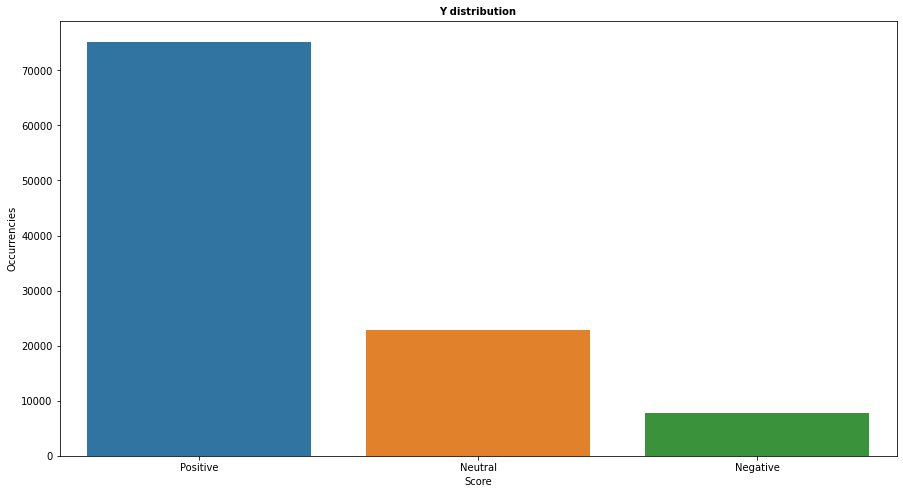

In [34]:
plt.figure(figsize=(15,8))
sns.countplot(x = processed_reviews['sentiment_pred'], order = sent_count.index)

plt.title("Y distribution", fontweight='bold', fontsize=10)
plt.xlabel("Score")
plt.ylabel("Occurrencies")
plt.xticks(np.arange(0,3,1), ['Positive', 'Neutral', 'Negative'])
plt.show()

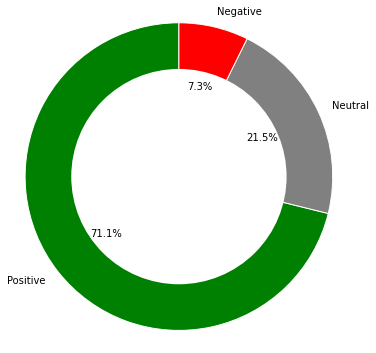

In [35]:
labels=['Positive','Neutral','Negative']

fig, ax = plt.subplots()
ax.pie(sent_count, labels=labels, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'white'}, colors= ['green', 'gray', 'red'])

centre_circle = plt.Circle((0, 0), 0.7, fc='white')
fig.gca().add_artist(centre_circle)

ax.axis('equal')
plt.subplots_adjust(top=1.3)
fig.patch.set_facecolor('white')
plt.show()


We see that the majority of reviews (71.1%) are positive, followed by neutral (21.5%) and negative (7.3).

Let us now plot two wordclouds to show the distribution of the most frequent words for both positive and negative reviews:

In [36]:
def lista_di_stringhe_a_stringa(lista):
    return ' '.join(eval(lista))

pos_feedback = ''.join(processed_reviews[processed_reviews['sentiment_pred']=='positive']['lemmatized_text'].apply(lista_di_stringhe_a_stringa))
neg_feedback = ''.join(processed_reviews[processed_reviews['sentiment_pred']=='negative']['lemmatized_text'].apply(lista_di_stringhe_a_stringa))

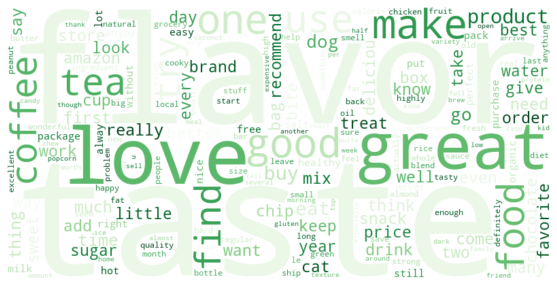

In [39]:
wordcloud_pos = WordCloud(width=800, height=400, background_color='white', colormap='Greens', random_state = 42, collocations = False).generate(pos_feedback)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.show()

In [42]:
top_words = dict(sorted(wordcloud_pos.words_.items(), key=lambda x: x[1], reverse=True)[:5])

print("Top 5 most frequent positive words:")
for word, frequency in top_words.items():
    print(f"{word}")

Top 5 most frequent positive words:
taste
flavor
love
great
good


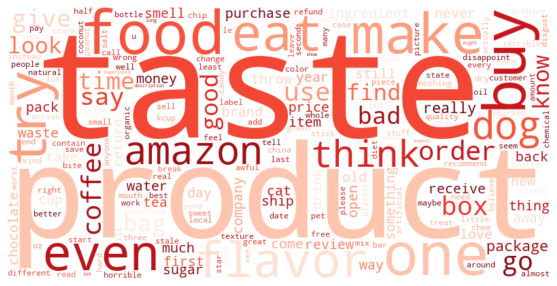

In [43]:
wordcloud_neg = WordCloud(width=800, height=400, background_color='white', colormap='Reds', random_state=42, collocations=False).generate(neg_feedback)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.show()

In [45]:
worst_words = dict(sorted(wordcloud_neg.words_.items(), key=lambda x: x[1], reverse=True)[:5])

print("Top 5 most frequent negative words:")
for word, frequency in worst_words.items():
    print(f"{word}")

Top 5 most frequent negative words:
taste
product
food
one
buy


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fad4abbb-8bc7-4ee9-9f5c-63fc95d85e92' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>